<a href="https://colab.research.google.com/github/SanketAinapure/ALL-Projects/blob/main/Complete_project_of_Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-bhqewp_q
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-bhqewp_q
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


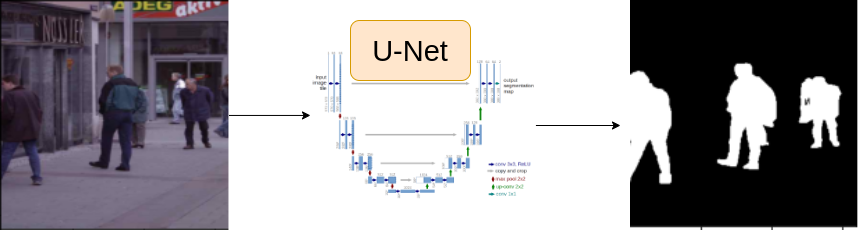

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn
import segmentation_models_pytorch as smp
import helper

# Task : 2 Setup Configurations

In [ ]:
# writing configuration

CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 5
LR = 0.003
IMG_SIZE = 256
BATCH_SIZE = 16

ENCODER = 'resnet18'
WEIGHTS = 'imagenet'

In [ ]:
#read the csv file

df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
#plot images

row = df.iloc[3] # value is changeable
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255


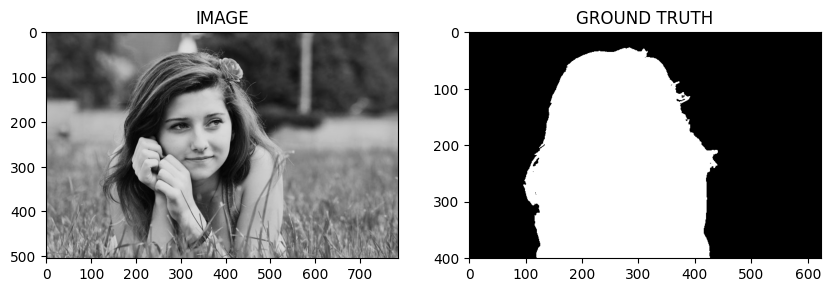

In [ ]:
# visualization code

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
#split dataset

#from pandas.core.common import random_state
#train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
# augmentation - brings variety in the dataset

import albumentations as A

In [ ]:
def get_train_augs():
 return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5),
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
      ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

# currently dimensions are (h,w,c) -> (c,h,w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask


In [ ]:
from pandas.core.common import random_state
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [ ]:
#idx = 3
#image, mask = trainset[idx]
#helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

print(f"total no.of batches in train loader : {len(trainloader)}")
print(f"total no.of batches in valid loader : {len(validloader)}")

for image, mask in trainloader:
    print(f"image of one image shape : {image.shape}")
    print(f"mask of one mask shape : {mask.shape}")
    break

total no.of batches in train loader : 15
total no.of batches in valid loader : 4
image of one image shape : torch.Size([16, 3, 256, 256])
mask of one mask shape : torch.Size([16, 1, 256, 256])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
class segmentationmodel(nn.Module):

  def __init__(self):
    super(segmentationmodel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = smp.losses.DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits


In [ ]:
model = segmentationmodel()
model.to(DEVICE)

segmentationmodel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0
  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

def eval_fn(data_loader, model, optimizer):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
     for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        logits, loss = model(images, masks)
        total_loss += loss.item()

  return total_loss / len(data_loader)


# Task 8 : Train Model

from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model, optimizer)

  if valid_loss < best_valid_loss:
      torch.save(model.state_dict(), 'best_model.pth')
      print('model saved')
      best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:15<00:00,  3.83s/it]


model saved
Epoch : 1 Train Loss : 0.74107639392217 Valid Loss : 1.0267277956008911


100%|██████████| 4/4 [00:15<00:00,  3.97s/it]


model saved
Epoch : 2 Train Loss : 0.6755234281222026 Valid Loss : 0.7671823352575302


100%|██████████| 4/4 [00:16<00:00,  4.08s/it]


model saved
Epoch : 3 Train Loss : 0.6468515396118164 Valid Loss : 0.6268697679042816


100%|██████████| 4/4 [00:16<00:00,  4.04s/it]


Epoch : 4 Train Loss : 0.5690094629923502 Valid Loss : 0.6443429440259933


100%|██████████| 4/4 [00:15<00:00,  3.96s/it]

Epoch : 5 Train Loss : 0.535893303155899 Valid Loss : 0.7005250304937363


# Task 9 : Inference

In [ ]:
model.load_state_dict(torch.load('/content/best_model.pth'))

image, mask = validset[4]

logits_masks = model(image.to(DEVICE).unsqueeze(0))
pred_masks = torch.sigmoid(logits_masks)
pred_masks = (pred_masks > 0.5)*1.0

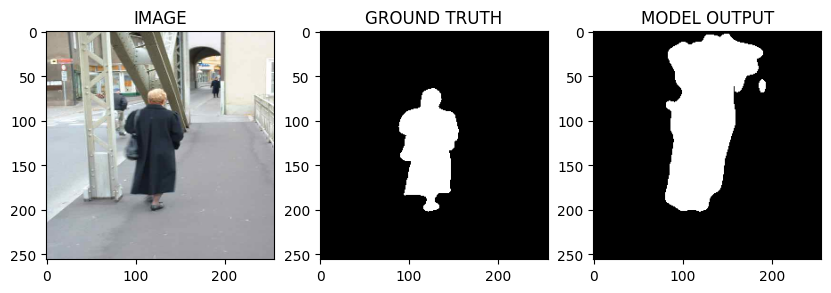

In [ ]:
helper.show_image(image, mask, pred_masks.detach().cpu().squeeze(0))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya